## RMSProp——从零开始
我们在“Adagrad——从零开始”一节里提到，由于调整学习率时分母上的变量s一直在累加按元素平方的小批量随机梯度，目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，Adagrad在迭代后期由于学习率过小，可能较难找到一个有用的解。为了应对这一问题，RMSProp算法对Adagrad做了一点小小的修改 [1]。

下面，我们来描述RMSProp算法。

### RMSProp算法
我们在“动量法——从零开始”一节里介绍过指数加权移动平均。事实上，RMSProp算法使用了小批量随机梯度按元素平方的指数加权移动平均变量$\gamma$，并将其中每个元素初始化为0。 给定超参数$\gamma$且$0 \leq \gamma < 1$， 在每次迭代中，RMSProp首先计算小批量随机梯度$\boldsymbol{g}$，然后对该梯度按元素平方项$\boldsymbol{g} \odot \boldsymbol{g}$做指数加权移动平均，记为$\boldsymbol{s}$：

$\boldsymbol{s} \leftarrow \gamma \boldsymbol{s} + (1 - \gamma) \boldsymbol{g} \odot \boldsymbol{g}.$.

然后，和Adagrad一样，将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$\boldsymbol{g}^\prime \leftarrow \frac{\eta}{\sqrt{\boldsymbol{s} + \epsilon}} \odot \boldsymbol{g},$

其中$\eta$是初始学习率且$\eta > 0$，$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-8}$。和Adagrad一样，模型参数中每个元素都分别拥有自己的学习率。同样地，最后的自变量迭代步骤与小批量随机梯度下降类似：

$\boldsymbol{x} \leftarrow \boldsymbol{x} - \boldsymbol{g}^\prime.$

需要强调的是，RMSProp只在Adagrad的基础上修改了变量$\boldsymbol{s}$的更新方法：对平方项$\boldsymbol{g} \odot \boldsymbol{g}$从累加变成了指数加权移动平均。由于变量$\boldsymbol{s}$可看作是最近$1/(1-\gamma)$个时刻的平方项$\boldsymbol{g} \odot \boldsymbol{g}$的加权平均，自变量每个元素的学习率在迭代过程中避免了“直降不升”的问题。

### RMSProp的实现
RMSProp的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [79]:
def RMSProp(params, grads, sqrs, lr, gamma, batch_size):
    for param, grad, sqr in zip(params, grads, sqrs):
        sqr[:] = gamma * sqr + (1 - gamma) * np.multiply(grad, grad)
        param[:] -= lr * grad / np.sqrt(sqr + 1e-5)
    return params, sqrs

## 实验
首先，导入本节中实验所需的包。

In [80]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import numpy as np
import random

sys.path.append('..')

实验中，我们以之前介绍过的线性回归为例。设数据集的样本数为1000，我们使用权重w为[2, -3.4]，偏差b为4.2的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

In [81]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = np.random.normal(scale=1, size=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += 0.01 * np.random.normal(scale=1, size=y.shape)

# 初始化模型参数。
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros((1,))
    sqrs = []
    params = [w, b]
    for param in params:
        sqrs.append(np.zeros(param.shape))
    return params, sqrs

# 构造迭代器。
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = np.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X[j], y[j]

# 线性回归模型。
def net(X, w, b):
    return np.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - np.reshape(y, yhat.shape)) ** 2 / 2

def cal_grad(yhat, y, X):
    grad_w = np.expand_dims(np.array([-np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 0]), -np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 1])]), axis=1)
    #grad_w = np.array([-np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 0])])
    grad_b = -np.sum((yhat - np.reshape(y, yhat.shape)))
    return [grad_w, grad_b]

优化函数optimize与“梯度下降和随机梯度下降——从零开始”一节中的类似。

In [82]:
import matplotlib as mpl

import matplotlib.pyplot as plt

def train(batch_size, lr, gamma, epochs, period):
    [w, b], sqrs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y))]
    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        # 学习率自我衰减。
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            output = net(data, w, b)
            loss = square_loss(output, label)
            grad =  cal_grad(label, output, data)
            [w, b], sqrs = RMSProp([w, b], grad, sqrs, lr, gamma, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(
                    np.mean(square_loss(net(X, w, b), y)))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w, (1, -1)),
          'b:', b, '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    mpl.rcParams['figure.figsize'] = 3.5, 2.5
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

我们将初始学习率设为0.03，并将$\gamma$（gamma）设为0.9。此时，变量$\boldsymbol{s}$可看作是最近$1/(1−0.9)=10$个时刻的平方项$\boldsymbol{g} \odot \boldsymbol{g}$的加权平均。我们观察到，损失函数在迭代后期较震荡。



Batch size 10, Learning rate 0.030000, Epoch 1, loss 1.3413e+00
Batch size 10, Learning rate 0.030000, Epoch 2, loss 2.7056e-04
Batch size 10, Learning rate 0.003000, Epoch 3, loss 6.8205e-05
('w:', array([[ 2.001152  , -3.39396709]]), 'b:', array([4.20044872]), '\n')


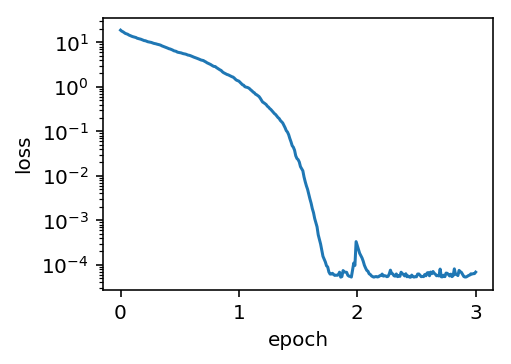

In [83]:
train(batch_size=10, lr=0.03, gamma=0.9, epochs=3, period=10)


我们将$\gamma$调大一点，例如0.999。此时，变量$\boldsymbol{s}$可看作是最近1/(1−0.999)=1000个时刻的平方项$\boldsymbol{g} \odot \boldsymbol{g}$的加权平均。这时损失函数在迭代后期较平滑。



/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in square
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size 10, Learning rate 0.030000, Epoch 1, loss nan
Batch size 10, Learning rate 0.030000, Epoch 2, loss nan
Batch size 10, Learning rate 0.003000, Epoch 3, loss nan
('w:', array([[nan, nan]]), 'b:', array([nan]), '\n')


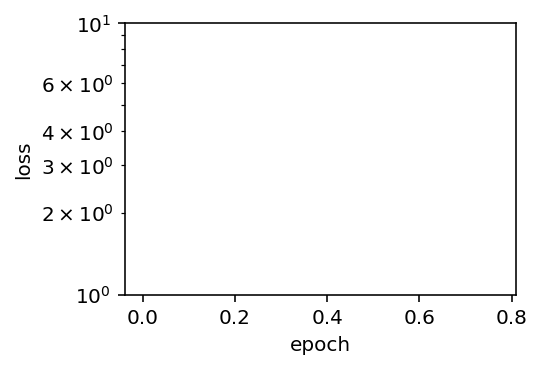

In [84]:
train(batch_size=10, lr=0.03, gamma=1, epochs=3, period=10)
